### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [4]:
States_track = collections.defaultdict(dict)

In [5]:
# Below are the list of state-action pairs that are tracked for convergence
sample_q_values = [
    ((1, 2, 4), (1, 2)),
    ((1, 8, 2), (1, 0))
]


# Initialise states-action dictonary to be tracked for convergence
def initialise_tracking_states():
    for q_values in sample_q_values:
        States_track[q_values[0]][q_values[1]] = []


# let initialise the States_track dictornary
initialise_tracking_states()

In [6]:
# function to add q-value for sampled q-value state-action pair
def save_tracking_states(env, agent, state_size):
    for state in States_track.keys():
        for action in States_track[state].keys():
            q_values = agent.model.predict(np.array(env.state_encod_arch1(state)).reshape(1, state_size))
            q_value = np.take(q_values[0], env.action_space.index(action))
            States_track[state][action].append(q_value)

In [7]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

## Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [8]:
class DQNAgent():
    def __init__(self, environment, action_size, state_size, hyperparameter):
        # Define size of state and action
        self.environment = environment
        self.state_size = state_size
        self.action_size = action_size

        # hyper parameters for the DQN
        self.discount_factor = hyperparameter['discount_factor']
        self.learning_rate = hyperparameter['learning_rate']
        self.epsilon = hyperparameter['epsilon']
        self.epsilon_max = hyperparameter['epsilon_max']
        self.epsilon_decay = hyperparameter['epsilon_decay']
        self.epsilon_min = hyperparameter['epsilon_min']
        
        self.batch_size = hyperparameter['batch_size']     
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    
    def set_epsilon(self, episode):
        """Method to set new epsilon based on current episode"""
        self.epsilon = self.epsilon_min + (
            self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay * episode)
        return self.epsilon

    def get_epsilon(self):
        """Return epsilon"""
        return self.epsilon


    # approximate Q function using Neural Network
    def build_model(self):
        """Build a model"""
        model = Sequential()

        # hidden layers
        model.add(Dense(36, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(36, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(36, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))

        return model


    def get_action(self, state):
        """
        get action in a state according to an epsilon-greedy approach
        """
        # get possible action index and actions from a given state 
        (possible_actions_index, actions) = self.environment.requests(state)

        # based on epsilon-greedy, either randomaly choose an action or max q-value action
        if random.uniform(self.epsilon_max, self.epsilon_min) < self.get_epsilon(): 
            # randomly choose the action index and corrosponding action
            index = random.randrange(len(possible_actions_index))
            return (possible_actions_index[index], actions[index])

        else:
            # convert given state to vector and get q-value vector
            state = np.array(self.environment.state_encod_arch1(state)).reshape(1, self.state_size)
            q_value = self.model.predict(state)
            
            # filter q-values for a possible action index
            filter_q_value = np.take(q_value[0], possible_actions_index)
            
            # check if offline action has higher q-value than accepting a drive request
            if q_value[0][0] > np.max(filter_q_value):
                # action index and action of offline
                return (0, actions[-1])
            else:
                # return max q-value action index and action
                return (possible_actions_index[np.argmax(filter_q_value)], actions[np.argmax(filter_q_value)])


    def append_sample(self, state, action, reward, next_state, done):
        # append the tuple (s, a, r, s', done) to memory (replay buffer) after every action
        self.memory.append((state, action, reward, next_state, done))


    def train_model(self):
        """
        train the neural network on a minibatch. Input to the network is the states,
        output is the target q-value corresponding to each action.
        """

        if len(self.memory) > self.batch_size:
            
            # sample minibatch from memory
            minibatch = random.sample(self.memory, self.batch_size)

            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = minibatch[i]
                update_input[i] = self.environment.state_encod_arch1(state)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = self.environment.state_encod_arch1(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)

            # target for q-network
            target_qval = self.model.predict(update_output)

            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

            # model fit
            history = self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

            # return neural network loss
            return history.history['loss']


    def save_model_weights(self, name):
        self.model.save_weights(name)


---
## Hyperparameters

In [9]:
Episodes = 20000

max_car_drive_time = 30 * 24

# hyperparameter of Agent class
Hyperparameters = {
    'discount_factor': 0.2,
    'learning_rate' : 0.001,
    'epsilon': 1,
    'epsilon_max' : 1,
    'epsilon_decay' : 0.0005,
    'epsilon_min': 0.01,
    'batch_size' : 32
}

# state size will no. of locations, no. of days and no. of days in a week. = 36
state_size = 36

# initialise CabDriver Environment
env = CabDriver()
# get action space from environment
(action_space, _, _) = env.reset()

action_size = len(action_space)

# initialise the DQNAgent with action_size, state_size and hyperparameter defined above
agent = DQNAgent(environment= env, action_size= action_size, state_size= state_size, hyperparameter= Hyperparameters)

# below variable are used for tracking rewards and neural network loss
(rewards_per_episode, nn_loss_per_episode) = ([],[])

---
## Training

In [10]:
start_time = time.time()

for episode in range(1, Episodes + 1):
    
    done = False
    total_reward = 0
    agent_total_time = 0
    
    (_, _, curr_state) = env.reset()
    
    while not done:
        # Pick epsilon-greedy action from possible actions for the current state
        agent.set_epsilon(episode)
        
        # Agent selecting trip/action on current state
        (action_index, action) = agent.get_action(curr_state)
        
        # Evaluate your reward and next state
        (next_state, reward, total_worked_hours) = env.step(curr_state, action, Time_matrix)
        
        # updating agent total time journey with time taken for each trip
        agent_total_time += total_worked_hours

        # check if agent total drive is over defined 30 days. This will be end of episode
        if agent_total_time >= max_car_drive_time:
            done = True
        
        # append the experience to the memory
        agent.append_sample(curr_state, action_index, reward, next_state, done)
        
        # train the model and also get the loss
        nn_loss = agent.train_model()

        # keep adding reward for each trip
        total_reward += reward
        
        # preparing current state to next state for the next 
        curr_state = next_state


    """ Keeping track to require data"""
    # keeping track to rewards. We would be evaluating total reward with respect to 30*24
    # rather than complete agent total time as it would be different in different cases. 
    # Aim is to get stablise the rewards in 30 days.
    total_reward = (total_reward/ agent_total_time) * max_car_drive_time
    rewards_per_episode.append(total_reward)
    
    # keeping track of neural network loss every episode
    nn_loss_per_episode.append(nn_loss)
    
    # keeping track of q-value for state-action pair defined in sample_q_values
    save_tracking_states(env, agent, state_size)

    
    # save weights every 1000 episode
    if episode % 1000 == 0:
        agent.save_model_weights(name="model_weights.h5")
    
    # display the current process and metrics
    if episode % 500 == 0:
        print('Episdoe:{} NN_loss:{} Reward:{} Epsilon:{}'.format(
            episode, agent_total_time, nn_loss, total_reward, agent.get_epsilon()))


        
# save rewards, nn_loss and tracked q-value
save_obj(rewards_per_episode,'Rewards_per_Episode')
save_obj(nn_loss_per_episode,'NN_Loss_per_Episode')
save_obj(States_track,'States_track')


elapsed_time = time.time() - start_time
print("Training completed. Time taken:[{}]".format(elapsed_time))

Episdoe:500 NN_loss:[1.1911323070526123] Reward:568.2644628099174 Epsilon:0.7810127752406908
Episdoe:1000 NN_loss:[2.7489609718322754] Reward:462.3578363384189 Epsilon:0.6104653531155071
Episdoe:1500 NN_loss:[4.339513301849365] Reward:956.6712898751734 Epsilon:0.47764288721360454
Episdoe:2000 NN_loss:[1.385354995727539] Reward:1295.8011049723757 Epsilon:0.3742006467597279
Episdoe:2500 NN_loss:[0.4311535656452179] Reward:1428.0497925311204 Epsilon:0.29363974889158817
Episdoe:3000 NN_loss:[0.06817921996116638] Reward:1542.9986244841814 Epsilon:0.23089885854694553
Episdoe:3500 NN_loss:[4.559386253356934] Reward:1486.9348127600554 Epsilon:0.1820362040159407
Episdoe:4000 NN_loss:[1.1154950857162476] Reward:1795.5186721991702 Epsilon:0.1439819304042466
Episdoe:4500 NN_loss:[0.46795710921287537] Reward:1880.9999999999998 Epsilon:0.11434523231624569
Episdoe:5000 NN_loss:[1.0561861991882324] Reward:1859.6685082872928 Epsilon:0.0912641486376598
Episdoe:5500 NN_loss:[0.011499661952257156] Reward:

---
## Tracking Convergence

### Check the states tracked for Q-values convergence

- Let check the convergence of state tracked q-value during training

In [11]:
with open('States_track.pkl', 'rb') as handle:
    States_track = pickle.load(handle)

In [12]:
for key, value in States_track.items():
    for k,v in value.items():
        print('[', key, k, ']:', len(v))

[ (1, 2, 4) (1, 2) ]: 20000
[ (1, 8, 2) (1, 0) ]: 20000


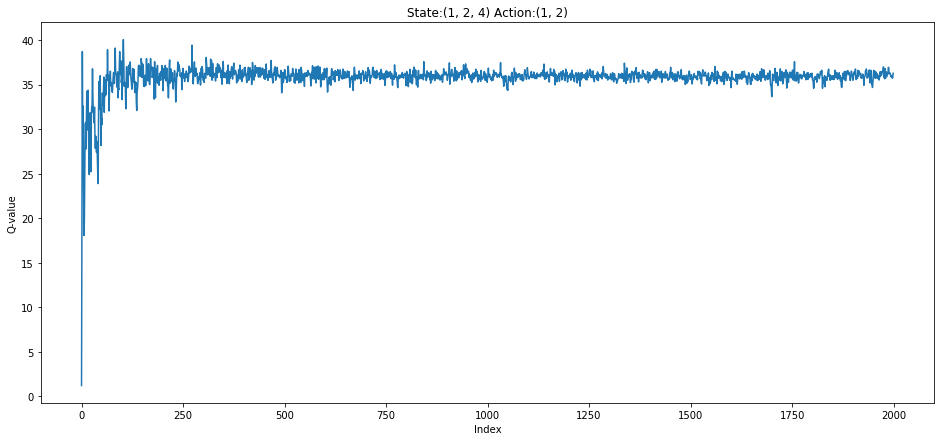

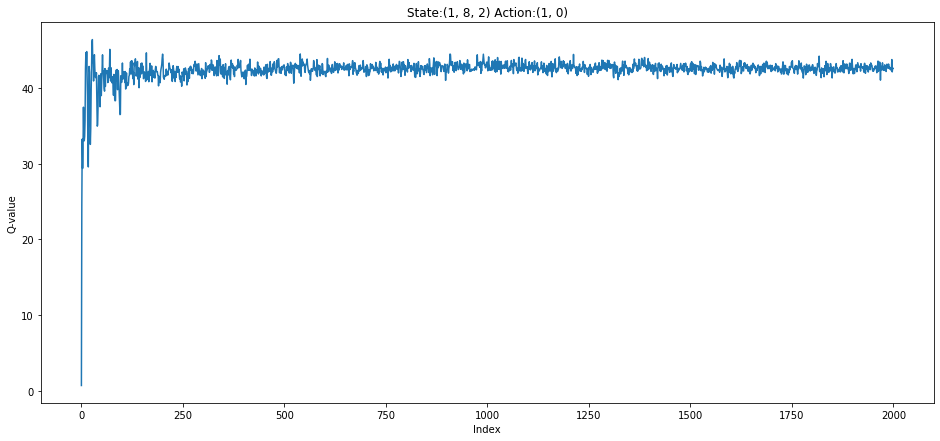

In [13]:
# Lets plot the convergence of Q-value state-action pair

plt.figure(0, figsize=(16,7))

# plot 1
plt.title('State:' + str(sample_q_values[0][0]) + ' ' +  'Action:' + str(sample_q_values[0][1]))
plt.xlabel('Index')
plt.ylabel('Q-value')
plt.plot(
    np.asarray(range(0, len(States_track[sample_q_values[0][0]].get(sample_q_values[0][1])[::10]))),
    np.asarray(States_track[sample_q_values[0][0]].get(sample_q_values[0][1])[::10]))
plt.show()


# plot 2
plt.figure(0, figsize=(16,7))
plt.title('State:' + str(sample_q_values[1][0]) + ' ' +  'Action:' + str(sample_q_values[1][1]))
plt.xlabel('Index')
plt.ylabel('Q-value')
plt.plot(
    np.asarray(range(0, len(States_track[sample_q_values[1][0]].get(sample_q_values[1][1])[::10]))),
    np.asarray(States_track[sample_q_values[1][0]].get(sample_q_values[1][1])[::10]))
plt.show()

Both the plots clearly indicate that it has converged and q-value is within a small margin. 

### Check the NN loss convergence

- Let check the convergence of Neural Network loss difference during training

In [14]:
# load the pickle file
with open('NN_Loss_per_Episode.pkl', 'rb') as handle:
    NN_Loss_per_Episode = pickle.load(handle)

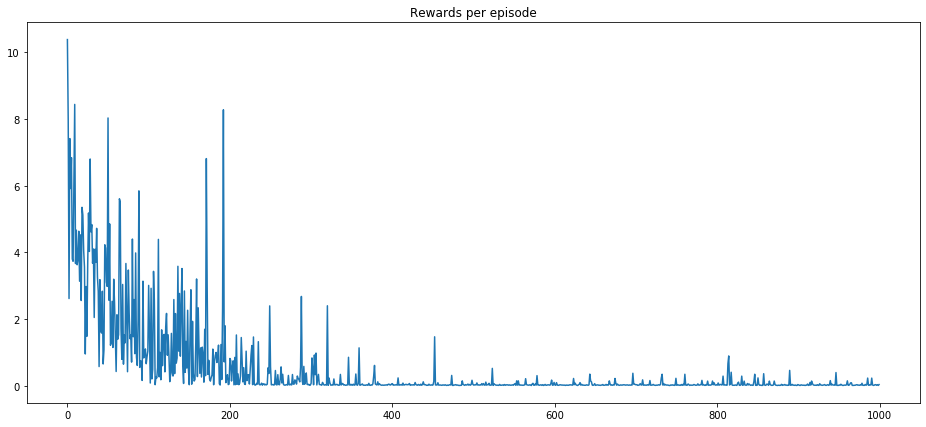

In [15]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(NN_Loss_per_Episode[::20])))
plt.plot(xaxis,np.asarray(NN_Loss_per_Episode[::20]))
plt.show()

Above plot clearly indicates epsilon-greedy way of choosing either random action or based on max q-value.

- Initial episodes Neural network is expected to have more loss because we wanted our model to explore more during start of initial training.
- In later half of training, we can observe that neural network has converged, it is below ~.01. This happened because we wanted to exploit and try to find best action from a given state.

### Check the Reward convergence

- Let check the convergence of Rewards achieved per episode during training

In [16]:
# load the pickle file
with open('Rewards_per_Episode.pkl', 'rb') as handle:
    Rewards_per_Episode = pickle.load(handle)

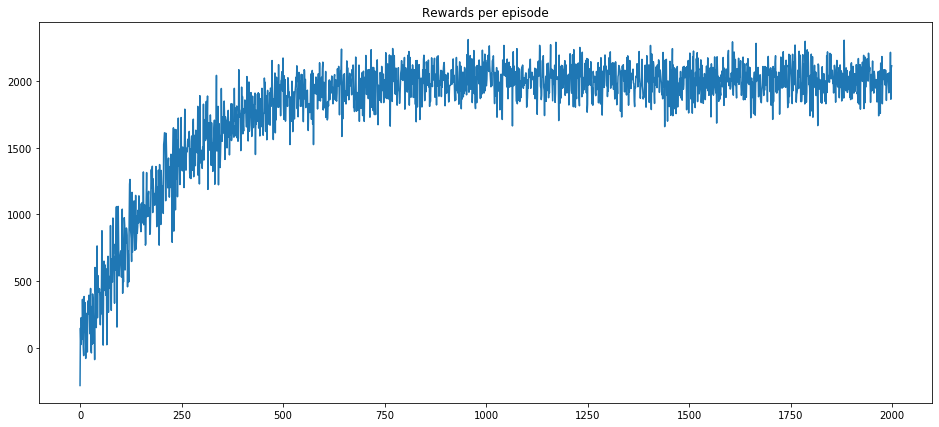

In [17]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(Rewards_per_Episode[::10])))
plt.plot(xaxis,np.asarray(Rewards_per_Episode[::10]))
plt.show()

Finding convergence for reward is quite difficult. Because of following reasons:

1. Initial state of agent(driver) is random. He can start from any location, any time, and day of week.
2. Chossing a right ride based on q-value. (Possible rides are also random)
3. Ride time also varies from location to location. Time and week days plays a major role of randomless.

Because of these factors, rewards hasn't converged to expectation. <br/>
But on an overall, Cab driver can efficiently get around 1800 to 2200 rewards as per above plot.

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [18]:
time = np.arange(0,20000)
epsilon = []
for i in range(0,20000):
    epsilon.append(0 + (1 - 0.01) * np.exp(-0.0005*i))

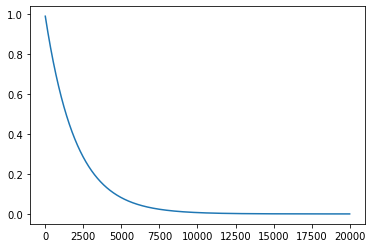

In [19]:
plt.plot(time, epsilon)
plt.show()